# **Open-Ended Section** 

For this section we had two different goals:
- Test if spliting our training data between two models holds a better result than having it all in one
- Build an analytics interface that returns a prediction when new input data is provided

### **Spliting the data**

While we were testing out and analyzing our previous results, we came to the conclusion that the majority of our models erros came from undervalueing expensive cars

In [ ]:
# TODO  adicionar o codigo que nos mostra que a maior parte dos erros veem dos carros caros

That led us to the idea of splitting our dataset into two different models: one for expensive cars and the other for more affordable ones. We would then train those models separately, divide our test data in the same way, predict each new dataset’s prices, and finally combine the two.

If we managed to find a good way of splitting the dataset while avoiding overfitting or undertraining our models, we could possibly circumvent the negative impact that cheaper models have on luxurious ones.

After looking at the distribution of prices across our variables, we reached the conclusion that the best way to split our dataset would be by Brand.

Average Price per Brand:
Brand
mercedes    24445.242247
audi        22949.133739
bmw         22676.948753
vw          16827.323602
skoda       14130.316296
hyundai     12816.681838
ford        12584.630906
toyota      12435.545538
opel        10398.261075
Name: price, dtype: float64


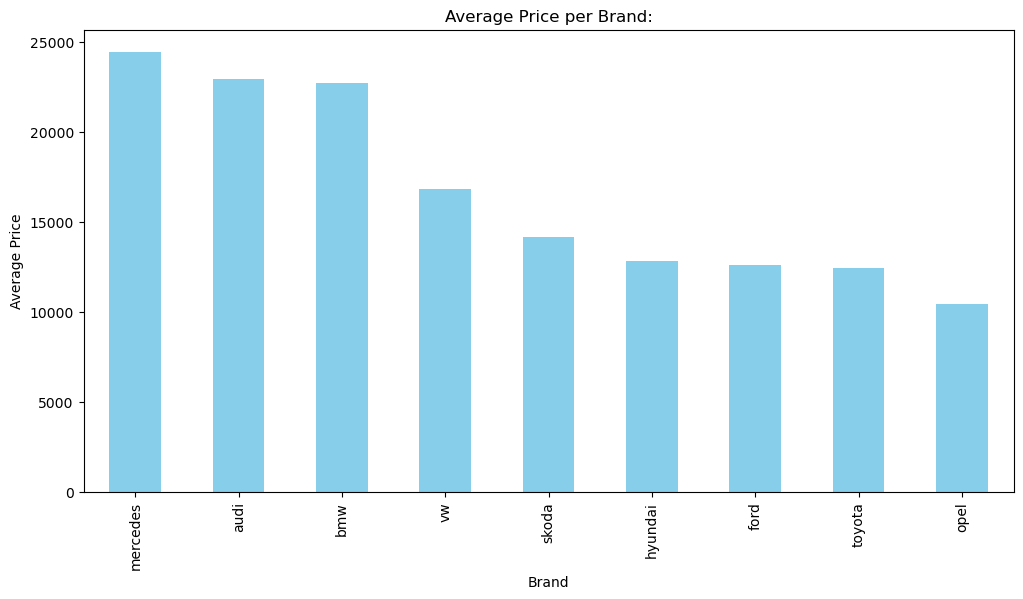

In [ ]:
train_db = pd.read_csv("./train.csv")
temp, temp_val_set = train_test_split(train_db, test_size=0.3, random_state=2, shuffle=True)

# - Fixing text columns -
# there are a lot of typos and different casings in all of the text columns
text_cols = temp.select_dtypes(include=["object"]).columns
temp[text_cols] = temp[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)
for col in text_cols:
    temp = f.fix_typos(col, temp)
 
brand_prices = temp.groupby('Brand')['price'].mean().sort_values(ascending=False)


print("Average Price per Brand:")
print(brand_prices)

# Graph
brand_prices.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Average Price per Brand:')
plt.ylabel('Average Price')
plt.show()

In [ ]:
# we do this to confirm that spliting our model into two (luxury_brands/others_brands) isn't farfetched
temp['price_range'] = np.where(
    temp['price'] < 16000,
    'Below 16000',
    'Above 16000'
)

counts = pd.crosstab(temp['Brand'], temp['price_range'])
counts = counts[['Below 16000', 'Above 16000']]
counts['Total'] = counts.sum(axis=1)

counts = counts.sort_values(by='Total', ascending=False)

print(counts)

price_range  Below 16000  Above 16000  Total
Brand                                       
ford                8645         2615  11260
mercedes            1543         6647   8190
vw                  3798         3464   7262
opel                6144          402   6546
bmw                 1609         3523   5132
audi                1470         3622   5092
toyota              2565          685   3250
skoda               2060          953   3013
hyundai             1828          523   2351


At 16000€ almost all Brans have the clear majority of their entries on one of the sides (other than vw, but we will inclued them in the lower bracket)

So we can confidently split our data into two:
- luxury_brands = ['mercedes', 'audi', 'bmw']
- others = ['ford', 'vw', 'opel', 'toyota', 'skoda', 'hyundai']

So now we just need to implement our hypothesis into our best model

### Proof of Concept: Random Forest Split

To validate this hypothesis, we applied the split strategy to the **Random Forest** model.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import randint


# --- 2. CARREGAMENTO E SPLIT ---
train_db = pd.read_csv("./train.csv")
train_db['price_log'] = np.log1p(train_db['price'])

train_set, val_set = train_test_split(train_db, test_size=0.3, random_state=42, shuffle=True)

train_set = clean_data(train_set)
val_set = clean_data(val_set)

luxury_brands = ['mercedes', 'audi', 'bmw']
mask_train = train_set['Brand'].str.lower().isin(luxury_brands)
mask_val = val_set['Brand'].str.lower().isin(luxury_brands)

train_lux = train_set[mask_train].copy()
train_oth = train_set[~mask_train].copy()
val_lux = val_set[mask_val].copy()
val_oth = val_set[~mask_val].copy()

In [ ]:
# --- 3. FUNÇÃO PRINCIPAL COM TESTE DE OVERFIT ---

# --- 4. EXECUÇÃO ---
model_lux_rf, sc_lux, map_lux, mean_lux, cols_lux = f.train_and_evaluate_rf(train_lux, val_lux, "LUXURY")
model_oth_rf, sc_oth, map_oth, mean_oth, cols_oth = f.train_and_evaluate_rf(train_oth, val_oth, "OTHERS")

# --- 5. PREDIÇÃO TESTE FINAL ---
test_db = pd.read_csv("./test.csv")
test_clean = clean_data(test_db)


mask_test = test_clean['Brand'].str.lower().isin(luxury_brands)
sub_lux = f.predict_group(test_clean[mask_test], model_lux_rf, sc_lux, map_lux, mean_lux, cols_lux)
sub_oth = f.predict_group(test_clean[~mask_test], model_oth_rf, sc_oth, map_oth, mean_oth, cols_oth)

submission = pd.concat([sub_lux, sub_oth]).sort_values("carID")
submission.to_csv("submission_overfit_checked.csv", index=False)
print("\nSubmissão salva com sucesso!")

After running our best model with this technique we achieved a vastly better result, while not reaching a concerning level of overfitting. 

The separation allowed the model to learn specific features of luxury cars (like depreciation curves) without the noise from the cheaper segment.

### The Final Architecture: Stacking Regressor

Given the success of the split strategy on the **Random Forest**, we decided to push for maximum performance. 

We expanded the ensemble to include **Extra Trees** and **HistGradientBoosting**, and combined them using a **Stacking Regressor** with **5-Fold Cross-Validation**.

We replicated the "Luxury vs. Others" training process for two additional distinct algorithms:

#### Split strategy applied to Extra Trees

In [ ]:

# --- 4. EXECUÇÃO DOS GRUPOS ---
print("--- INICIANDO MODELAGEM LUXURY ---")
model_lux_et, sc_lux, map_lux, mean_lux, cols_lux = f.train_and_evaluate_et(train_lux, val_lux, "LUXURY")

print("\n--- INICIANDO MODELAGEM OTHERS ---")
model_oth_et, sc_oth, map_oth, mean_oth, cols_oth = f.train_and_evaluate_et(train_oth, val_oth, "OTHERS")

# --- 5. PREDIÇÃO TESTE FINAL ---
test_db = pd.read_csv("./test.csv")
test_clean = clean_data(test_db) # Usa a tua função de limpeza

# Separar teste
mask_test = test_clean['Brand'].str.lower().isin(luxury_brands)

# Prever separadamente
sub_lux = f.predict_group(test_clean[mask_test], model_lux_et, sc_lux, map_lux, mean_lux, cols_lux)
sub_oth = f.predict_group(test_clean[~mask_test], model_oth_et, sc_oth, map_oth, mean_oth, cols_oth)

# Juntar e Salvar
submission = pd.concat([sub_lux, sub_oth]).sort_values("carID")
submission.to_csv("submission_extratrees_split.csv", index=False)
print("\nSubmissão 'submission_extratrees_split.csv' salva com sucesso!")

#### Split strategy applied to Hist Gradient Boosting

In [ ]:
# --- 4. EXECUÇÃO DOS GRUPOS ---
print("--- INICIANDO MODELAGEM LUXURY (HistGB) ---")
model_lux_hgb, sc_lux, map_lux, mean_lux, cols_lux = f.train_and_evaluate_hgb(train_lux, val_lux, "LUXURY")

print("\n--- INICIANDO MODELAGEM OTHERS (HistGB) ---")
model_oth_hgb, sc_oth, map_oth, mean_oth, cols_oth = f.train_and_evaluate_hgb(train_oth, val_oth, "OTHERS")

# --- 5. PREDIÇÃO TESTE FINAL ---
test_db = pd.read_csv("./test.csv")
test_clean = clean_data(test_db) 

# Separar teste
mask_test = test_clean['Brand'].str.lower().isin(luxury_brands)

# Prever separadamente
sub_lux = f.predict_group(test_clean[mask_test], model_lux_hgb, sc_lux, map_lux, mean_lux, cols_lux)
sub_oth = f.predict_group(test_clean[~mask_test], model_oth_hgb, sc_oth, map_oth, mean_oth, cols_oth)

# Juntar e Salvar
submission = pd.concat([sub_lux, sub_oth]).sort_values("carID")
submission.to_csv("submission_histgb_split.csv", index=False)
print("\nSubmissão 'submission_histgb_split.csv' salva com sucesso!")

After validating that the "Split Strategy" (Luxury vs. Others) improved performance for individual algorithms, we moved to the next logical step: Model Ensembling.

We know that:

`Random Forest` is robust and handles outliers well.

`Extra Trees` reduces variance through randomness.

`HistGradientBoosting` is excellent at reducing bias and capturing complex non-linear patterns.

Instead of relying on a single algorithm, we decided to combine these three "specialists" into a unified prediction system. We approached this in two stages: Weighted Voting and Stacking.

### Stage 1: Optimized Weighted Voting

Our first ensemble approach was a Voting Regressor. A standard voting regressor simply averages the predictions of all models. However, we hypothesized that for Luxury Cars, one model might be significantly better than the others, whereas for Common Cars, a balanced mix might be superior.

To test this, we implemented a Stochastic Weight Optimization:

We defined a search space where each model (RF, ET, HGB) is assigned a weight from 0 to 100.

We introduced a 20% probability of dropping a model entirely (weight=0). This acts as automatic model selection.

We used RandomizedSearchCV to find the exact optimal weight combination for the Luxury segment and the Other segment separately.

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit

# --- 1. RECOLHER OS MODELOS JÁ TREINADOS ---
# Tens de garantir que estas variáveis existem. 
# Se sobrescreveste 'model_lux' nas células anteriores, tens de voltar atrás e correr os treinos 
# (ou atribuir nomes diferentes) para teres os 3 disponíveis simultaneamente.

# Exemplo de como devem estar organizados (substitui pelas tuas variáveis reais):
models_luxury = {
    'RF': model_lux_rf,   # O teu melhor Random Forest (Luxury)
    'ET': model_lux_et,   # O teu melhor Extra Trees (Luxury)
    'HGB': model_lux_hgb  # O teu melhor HistGradientBoosting (Luxury)
}

models_others = {
    'RF': model_oth_rf,   # O teu melhor Random Forest (Others)
    'ET': model_oth_et,   # O teu melhor Extra Trees (Others)
    'HGB': model_oth_hgb  # O teu melhor HistGradientBoosting (Others)
}

# --- 2. PREPARAR DADOS (Recuperar X e y para cada grupo) ---
# Precisamos disto para o 'fit' do VotingRegressor conseguir calcular os erros e ajustar pesos

# (Assume-se que train_lux, val_lux, train_oth, val_oth já existem da célula anterior)

# Preparar dados Luxo
print(">>> A preparar dados LUXURY...")
X_lux_comb, y_lux_comb, ps_lux, sc_lux, map_lux, mean_lux, cols_lux = f.prepare_data_for_ensemble(train_lux, val_lux)

# Preparar dados Outros
print(">>> A preparar dados OTHERS...")
X_oth_comb, y_oth_comb, ps_oth, sc_oth, map_oth, mean_oth, cols_oth = f.prepare_data_for_ensemble(train_oth, val_oth)



# --- 4. EXECUTAR OTIMIZAÇÃO ---
print("\n=== ENSEMBLE LUXURY ===")
ensemble_lux = f.optimize_ensemble_weights(models_luxury, X_lux_comb, y_lux_comb, ps_lux, "LUXURY")

print("\n=== ENSEMBLE OTHERS ===")
ensemble_oth = f.optimize_ensemble_weights(models_others, X_oth_comb, y_oth_comb, ps_oth, "OTHERS")


# --- 5. SUBMISSÃO FINAL (ENSEMBLE SPLIT) ---
test_db = pd.read_csv("./test.csv")
test_clean = clean_data(test_db)


mask_test = test_clean['Brand'].str.lower().isin(['mercedes', 'audi', 'bmw'])

sub_lux = f.predict_ensemble(test_clean[mask_test], ensemble_lux, sc_lux, map_lux, mean_lux, cols_lux)
sub_oth = f.predict_ensemble(test_clean[~mask_test], ensemble_oth, sc_oth, map_oth, mean_oth, cols_oth)

submission = pd.concat([sub_lux, sub_oth]).sort_values("carID")
submission.to_csv("submission_ensemble_split_optimized.csv", index=False)
print("\n✅ Submissão 'submission_ensemble_split_optimized.csv' criada com sucesso!")

#### The Final Architecture: Stacking Regressor

To achieve the maximum possible performance, we combined our three split-optimized models (**Random Forest**, **Extra Trees**, and **HistGradientBoosting**) using a **Stacking Regressor**.

Unlike a simple Voting Regressor (which just averages predictions), Stacking trains a "Meta-Model" to learn how to combine the base models best.

`Base Models`: RF, ET, and HGB (trained separately on Luxury and Others).

`Meta-Model`: RidgeCV (chosen to handle collinearity between the base predictions).

`Validation Strategy`: We used 5-Fold Cross-Validation inside the Stacking Regressor. This ensures the Meta-Model learns from out-of-sample predictions on the entire dataset, avoiding data leakage.

In [ ]:
import functionsML as f  # Importar o teu ficheiro novo

# --- 1. DEFINIR OS MODELOS AQUI (Onde as variáveis existem) ---
# Lista para LUXURY
estimators_lux = [
    ('rf', model_lux_rf),
    ('et', model_lux_et),
    ('hgb', model_lux_hgb)
]

# Lista para OTHERS
estimators_oth = [
    ('rf', model_oth_rf),
    ('et', model_oth_et),
    ('hgb', model_oth_hgb)
]

# --- 2. CHAMAR A FUNÇÃO DO FICHEIRO ---

# Carregar dados (garantindo que estão limpos)
test_db = pd.read_csv("./test.csv")
test_clean = clean_data(test_db)

# Split Teste
mask_test_lux = test_clean['Brand'].str.lower().isin(['mercedes', 'audi', 'bmw'])
test_lux = test_clean[mask_test_lux].copy()
test_oth = test_clean[~mask_test_lux].copy()

# A. Stacking Luxury
# Repara que passamos 'estimators_lux' como argumento extra
sub_lux = f.train_stacking(train_lux, val_lux, test_lux, estimators=estimators_lux, group_name="LUXURY")

# B. Stacking Others
sub_oth = f.train_stacking(train_oth, val_oth, test_oth, estimators=estimators_oth, group_name="OTHERS")

# --- 3. EXPORTAR ---
submission_stack = pd.concat([sub_lux, sub_oth]).sort_values("carID")
submission_stack.to_csv("submission_stacking_5fold.csv", index=False)
print("\n🚀 Submissão criada com sucesso!")